# Cumulative Distribution Functions

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Percentiles and Percentile Ranks

If you have taken a standardized test, you probably got your results in the form of a raw score and a **percentile rank**.
In this context, the percentile rank is the percentage of people who got the same score as you or lower.
So if you are "in the 90th percentile," you did as well as or better than 90% of the people who took the exam.

To understand percentiles and percentile ranks, let's consider an example based on running speeds.
Some years ago I ran the James Joyce Ramble, which is a 10 kilometer road race in Massachusetts.
After the race, I downloaded the results so to see how my time compared to other runners.
The `relay.py` module provides a function that reads the results and returns a Pandas `DataFrame`.

In [20]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/relay.py")
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/Apr25_27thAn_set1.shtml"
)

<IPython.core.display.Javascript object>

In [138]:
from relay import read_results

results = read_results()
results.head()

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
0,1,1/362,M2039,30:43,30:42,4:57,12.121212
1,2,2/362,M2039,31:36,31:36,5:06,11.764706
2,3,3/362,M2039,31:42,31:42,5:07,11.726384
3,4,4/362,M2039,32:28,32:27,5:14,11.464968
4,5,5/362,M2039,32:52,32:52,5:18,11.320755


<IPython.core.display.Javascript object>

`results` contains one row for each of 1633 runners who finished the race.
The column we'll use to quantify performance is `MPH`, which contains each runner's average speed in miles per hour.
We'll select this column and use `values` to extract the speeds as a NumPy array.

In [158]:
speeds = results["MPH"].values

<IPython.core.display.Javascript object>

I finished in 42:44, so we can find my row like this.

In [159]:
my_result = results.query("Nettime == '42:44'")
my_result

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
96,97,26/256,M4049,42:48,42:44,6:53,8.716707


<IPython.core.display.Javascript object>

The index of my row is 96, so we can extract my speed like this.

In [160]:
my_speed = speeds[96]

<IPython.core.display.Javascript object>

We can use `sum` to count the number of runners at my speed or slower.

In [161]:
(speeds <= my_speed).sum()

1537

<IPython.core.display.Javascript object>

And we can use `mean` to compute the percentage of runners at my speed or slower.

In [191]:
(speeds <= my_speed).mean() * 100

94.12124923453766

<IPython.core.display.Javascript object>

The result is my percentile rank in the field, which was about 94%.

More generally, the following functions computes the percentile rank of a particular value in a sequence of values.

In [192]:
def percentile_rank(x, seq):
    """Percentile rank of x.

    x: value
    seq: sequence of values

    returns: percentile rank 0-100
    """
    return (seq <= x).mean() * 100

<IPython.core.display.Javascript object>

In `results`, the `Division` column indicates the division each runner was in, identified by gender and age range -- for example, I was in the M4040 division, which includes male runners aged 40 to 49.
We can use the `query` method to select the rows for people in my division and extract their speeds.

In [ ]:
my_division = results.query("Division == 'M4049'")
my_division_speeds = my_division["MPH"].values

Now we can use `percentile_rank` to compute my percentile rank in my division.

In [193]:
percentile_rank(my_speed, my_division_speeds)

90.234375

<IPython.core.display.Javascript object>

Going in the other direction, if we are given a percentile rank, the following function finds the corresponding value in a sequence.

In [199]:
def percentile(p, seq):
    n = len(seq)
    i = (1 - p / 100) * (n + 1)
    return seq[round(i)]

<IPython.core.display.Javascript object>

`n` is the number of elements in the sequence; `i` is the index of the element with the given percentile rank.

When we look up a percentile rank, the corresponding value is called a **percentile**.

In [222]:
percentile(90, my_division_speeds)

8.591885441527447

<IPython.core.display.Javascript object>

In my division, the 90th percentile was about 8.5 mph.

If I am still running in 10 years (and I hope I am), I will be in the `M5059` division.
[NOTE FOR THE THIRD EDITION: I am.]
Assuming that my percentile rank in my division is the same, how much slower should I expect to be?
We can answer that question by converting my percentile rank in the `M4049` division, which is about 90.2%, to a speed in the `M5059` division.

In [201]:
next_division = results.query("Division == 'M5059'")
next_division_speeds = next_division["MPH"].values

percentile(90.2, next_division_speeds)

8.017817371937639

<IPython.core.display.Javascript object>

The person in the `M5059` division with the same percentile rank as me ran just over 8 mph.
We can use `query` to find him.

In [198]:
next_division.query("MPH > 8.01").tail(1)

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
222,223,18/171,M5059,46:30,46:25,7:29,8.017817


<IPython.core.display.Javascript object>

He finished in 46:25 and came in 18th out of 171 people in his division.

The goal of these examples is to introduce percentile ranks and percentiles, which are the key to understanding cumulative distribution functions.

## CDFs

A **cumulative distribution function**, or CDF, is a way to describe the distribution of a set of values.
Given a value `x`, the CDF computes the fraction of values less than or equal to `x`.
As an example, we'll start with a short sequence.

In [202]:
t = [1, 2, 2, 3, 5]

<IPython.core.display.Javascript object>

One way to compute a CDF is to start with a PMF.
Here is a `Pmf` object that represents the distribution of values in `t`.

In [228]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(t)
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


<IPython.core.display.Javascript object>

We can use the bracket operator to look up a value in a `Pmf`.

In [230]:
pmf[2]

0.4

<IPython.core.display.Javascript object>

The result is the proportion of values in the sequence equal to the given value.
In this example, two out of five values are equal to `2`, so the result is 0.4, which is two fifths.
We can also think of this proportion as the probability that a randomly chosen value from the sequence equals `2`.

`Pmf` has a `make_cdf` method that computes the cumulative sum of the probabilities in the `Pmf`.

In [233]:
cdf = pmf.make_cdf()
cdf

,probs
1,0.2
2,0.6
3,0.8
5,1.0


<IPython.core.display.Javascript object>

The result is a `Cdf` object, which is a kind of Pandas `Series`.
We can use the bracket operator to look up a value.

In [231]:
cdf[2]

0.6000000000000001

<IPython.core.display.Javascript object>

The result is the proportion of values in the sequence less than or equal to the given value. In this example, three out of five of the values in the sequence are less than or equal to `2`, so the result is 0.6, which is three fifths.
We can also think of this proportion as the probability that a randomly chosen value from the sequence is less than or equal to `2`.

We can also use parentheses to call the `Cdf` object like a function.

In [206]:
cdf(3)

array(0.8)

<IPython.core.display.Javascript object>

The cumulative distribution function is defined for all numbers, not just the ones that appear in the sequence.

In [207]:
cdf(4)

array(0.8)

<IPython.core.display.Javascript object>

To visualize the `Cdf`, we can use the `step` method, which plots the `Cdf` as a step function.

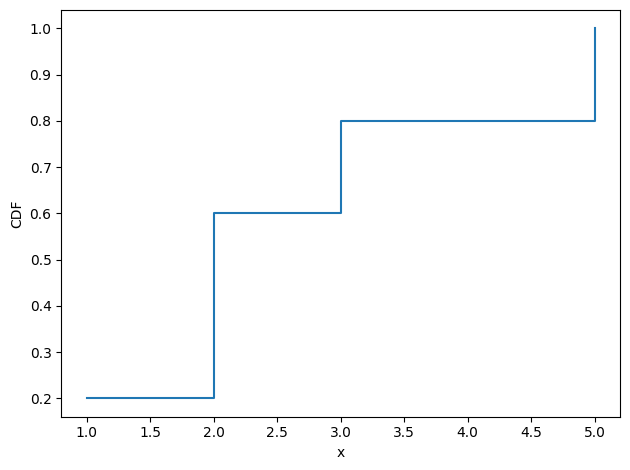

<IPython.core.display.Javascript object>

In [211]:
cdf.step()
decorate(xlabel="x", ylabel="CDF")

As a second example, let's make a `Cdf` that represents the distribution of running speeds from the previous section.
The `Cdf` class that provides a `from_seq` function we can use to create a `Cdf` object from a sequence, without making a `Pmf` first.

In [212]:
cdf_speeds = Cdf.from_seq(speeds)

<IPython.core.display.Javascript object>

And here's what it looks like.

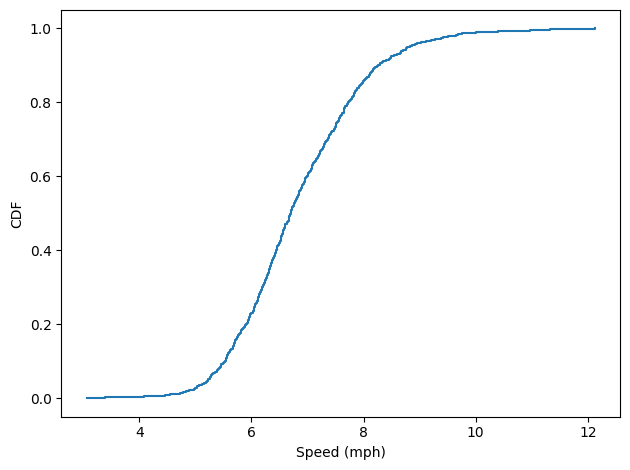

<IPython.core.display.Javascript object>

In [213]:
cdf_speeds.step()
decorate(xlabel="Speed (mph)", ylabel="CDF")

If we look up my speed, the result is the fraction of runners at my speed or slower.
If we multiply by 100, we get my percentile rank.

In [220]:
cdf_speeds(my_speed) * 100

94.12124923453766

<IPython.core.display.Javascript object>

So that's one way to think about the `Cdf` -- given a value, it computes something like a percentile rank, except that it's a proportion between 0 and 1 rather than a percentage between 0 and 100.

`Cdf` provides an `inverse` method that computes the inverse of the cumulative distribution function -- given a proportion between 0 and 1, it finds the corresponding value.

For example, if someone says they ran as fast or faster than 50% of the field, we can find their speed like this.

In [221]:
cdf_speeds.inverse(0.5)

array(6.70391061)

<IPython.core.display.Javascript object>

If you have a proportion and you use the inverse CDF to find the corresponding value, the result is called a **quantile** -- so the inverse CDF is sometimes called the quantile function.

If have have a quantile and you use the CDF to find the corresponding proportion, the result doesn't really have a name, strangely.
To be consistent with percentile and percentile rank", it could be called a "quantile rank", but as far as I can tell, no one calls it that.
Most often, it is called a **cumulative probability**.

## Comparing CDFs

CDFs are especially useful for comparing distributions.
As an example, let's compare the distribution of birth weights for first babies and others.
We'll load the NSFG dataset again, and divide it into three `DataFrames`: all live births, first babies, and others.

In [234]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [235]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

From `firsts` and `others` we'll select total birth weights in pounds, using `dropna` to remove values that are `nan`.

In [259]:
first_weights = firsts["totalwgt_lb"].dropna()
first_weights.mean()

7.201094430437772

<IPython.core.display.Javascript object>

In [260]:
other_weights = others["totalwgt_lb"].dropna()
other_weights.mean()

7.325855614973262

<IPython.core.display.Javascript object>

As we saw in Section xxx, first babies are a little lighter on average.
But there are several ways a difference like that could happen -- for example, there might be a small number of first babies who are especially light, or a small number of other babies who are especially heavy, but the result of the distribution might look the same.
In those cases, the distributions would have different shapes.
As another possibility, the distributions might have the same shape, but different locations.

To compare the distributions, we can try plotting the PMFs.

In [244]:
from empiricaldist import Pmf

first_pmf = Pmf.from_seq(first_weights, name="first")
other_pmf = Pmf.from_seq(other_weights, name="other")

<IPython.core.display.Javascript object>

But it doesn't work very well.

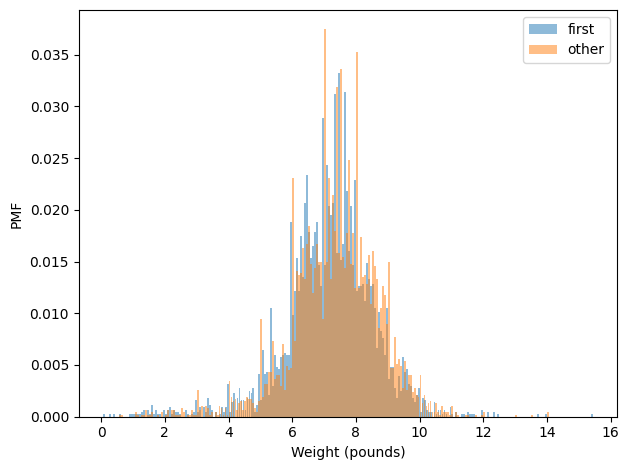

<IPython.core.display.Javascript object>

In [258]:
from thinkstats import two_bar_plots

two_bar_plots(first_pmf, other_pmf, width=0.06, alpha=0.5)
decorate(xlabel="Weight (pounds)", ylabel="PMF")

I adjusted the width and transparency of the bars to show the distributions as clearly as possible, but it is hard to compare them.
There are many peaks and valleys, and some apparent differences, but it is hard to tell which of these features are meaningful.
Also, it is hard to see overall patterns -- for example, it is not visually apparent which distribution has the higher mean.

These problems can be mitigated by binning the data -- that is, dividing the range of quantities into non-overlapping intervals and counting the number of quantities in each bin.
Binning can be useful, but it is tricky to get the size of the bins right.
If they are big enough to smooth out noise, they might also smooth out useful information.

A good alternative is to plot the CDFs.

In [261]:
first_cdf = first_pmf.make_cdf()
other_cdf = other_pmf.make_cdf()

<IPython.core.display.Javascript object>

Here's what they look like.

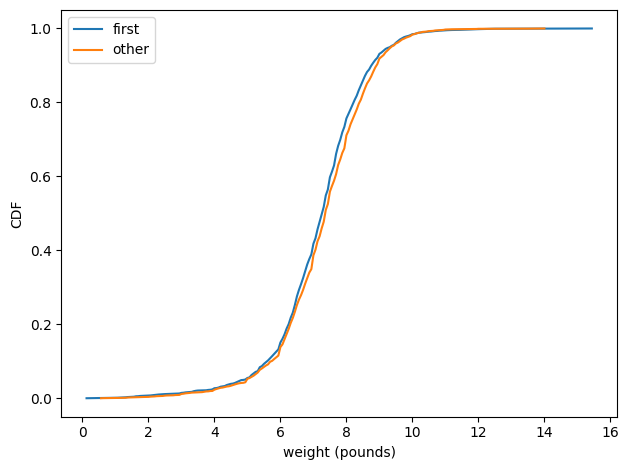

<IPython.core.display.Javascript object>

In [262]:
first_cdf.plot()
other_cdf.plot()
decorate(xlabel="Weight (pounds)", ylabel="CDF")

This figure makes the shape of the distributions, and the differences between them, much clearer.
We can see that first babies are slightly lighter throughout the distribution, with a larger discrepancy above the midpoint.

## Percentile-Based Statistics

In Section xxx we computed the arithmetic mean, which identifies a central point in a distribution, and the standard deviations, which quantifies how spread out the distribution is.
And in Section xxx we computed Pearson's skewness, which indicates whether a distribution is skewed left or right.
One drawback of all of these statistics is that they are sensitive to outliers.
A single extreme value in a dataset can have a large effect on mean, standard deviation, and skewness.

An alternative is to use statistics that are based on percentiles of the distribution, which tend to be more **robust**, which means that they are less sensitive to outliers.

To demonstrate, let's load the NSFG data again without doing any data cleaning.

In [299]:
from thinkstats import read_stata

dct_file = "2002FemPreg.dct"
dat_file = "2002FemPreg.dat.gz"

preg = read_stata(dct_file, dat_file)

<IPython.core.display.Javascript object>

In [300]:
birthwgt_lb = preg["birthwgt_lb"]
birthwgt_oz = preg["birthwgt_oz"]

<IPython.core.display.Javascript object>

In [301]:
from empiricaldist import Hist

Hist.from_seq(birthwgt_lb).tail(5)

,freqs
birthwgt_lb,
15.0,1
51.0,1
97.0,1
98.0,1
99.0,57


<IPython.core.display.Javascript object>

In [302]:
Hist.from_seq(birthwgt_oz).tail(5)

,freqs
birthwgt_oz,
14.0,475
15.0,378
97.0,1
98.0,1
99.0,46


<IPython.core.display.Javascript object>

In [303]:
total_weight_bogus = birthwgt_lb + birthwgt_oz / 16

<IPython.core.display.Javascript object>

In [304]:
birthwgt_lb_clean = birthwgt_lb.replace([51, 97, 98, 99], np.nan)
birthwgt_oz_clean = birthwgt_oz.replace([97, 98, 99], np.nan)

total_weight_clean = birthwgt_lb_clean + birthwgt_oz_clean / 16

<IPython.core.display.Javascript object>

In [305]:
total_weight_bogus.mean(), total_weight_clean.mean()

(7.319680587652691, 7.265628457623368)

<IPython.core.display.Javascript object>

In [306]:
total_weight_bogus.std(), total_weight_clean.std()

(2.096001779161835, 1.4082934455690173)

<IPython.core.display.Javascript object>

In [307]:
def skewness(seq):
    deviations = seq - seq.mean()
    return np.mean(deviations**3) / seq.std(ddof=0) ** 3

<IPython.core.display.Javascript object>

In [308]:
skewness(total_weight_bogus), skewness(total_weight_clean)

(22.251846195422484, -0.5895062687577697)

<IPython.core.display.Javascript object>

Once you have computed a CDF, it is easy to compute percentiles and percentile ranks.
To demonstrate, let's compute a `Cdf` that represent the distribution of birth weights.

In [331]:
def median(cdf):
    m = cdf.inverse(0.5)
    return m

<IPython.core.display.Javascript object>

In [332]:
cdf_total_weight_bogus = Cdf.from_seq(total_weight_bogus)
cdf_total_weight_clean = Cdf.from_seq(total_weight_clean)

<IPython.core.display.Javascript object>

In [333]:
median(cdf_total_weight_bogus), median(cdf_total_weight_clean)

(array(7.375), array(7.375))

<IPython.core.display.Javascript object>

Another percentile-based statistic is the **interquartile range** (IQR), which is a measure of the spread of a distribution.
The IQR is the difference between the 75th and 25th percentiles.

In [325]:
def iqr(cdf):
    low, high = cdf.inverse([0.25, 0.75])
    return high - low

<IPython.core.display.Javascript object>

In [326]:
iqr(cdf_total_weight_bogus), iqr(cdf_total_weight_clean)

(1.625, 1.625)

<IPython.core.display.Javascript object>

Quartile skewness

In [334]:
def quartile_skewness(cdf):
    low, median, high = cdf.inverse([0.25, 0.5, 0.75])
    midpoint = (high + low) / 2
    semi_iqr = (high - low) / 2
    return (midpoint - median) / semi_iqr

<IPython.core.display.Javascript object>

In [335]:
(quartile_skewness(cdf_total_weight_bogus), quartile_skewness(cdf_total_weight_clean))

(-0.07692307692307693, -0.07692307692307693)

<IPython.core.display.Javascript object>

More generally, percentiles are often used to summarize the shape of a distribution.
For example, the distribution of income is often reported in "quintiles"; that is, it is split at the 20th, 40th, 60th and 80th percentiles.
Other distributions are divided into ten "deciles".
Statistics like these that represent equally-spaced points in a CDF are called **quantiles**.
For more, see <https://en.wikipedia.org/wiki/Quantile>.

## Random numbers

Suppose we choose a random sample from the population of live births and look up the percentile rank of their birth weights.
Now suppose we compute the CDF of the percentile ranks.
What do you think the distribution will look like?

Here's how we can compute it. First, we make the `Cdf` of birth weights:

In [ ]:
weights = live.totalwgt_lb
cdf = Cdf.from_seq(weights, name="totalwgt_lb")

Then we generate a sample and compute the percentile rank of each quantity in the sample.

In [ ]:
import numpy as np

sample = np.random.choice(weights, 100, replace=True)
ranks = [cdf(x) * 100 for x in sample]

`sample` is a random sample of 100 birth weights, chosen with **replacement**; that is, the same quantity could be chosen more than once.
`ranks` is a list of percentile ranks.

Finally we make and plot the `Cdf` of the percentile ranks.

In [ ]:
rank_cdf = Cdf.from_seq(ranks, name="ranks")
rank_cdf.plot()
decorate(xlabel="percentile rank", ylabel="CDF")

This figure shows the result.
The CDF is approximately a straight line, which means that the distribution is uniform.

That outcome might be non-obvious, but it is a consequence of the way the CDF is defined.
What this figure shows is that 10% of the sample is below the 10th percentile, 20% is below the 20th percentile, and so on, exactly as we should expect.

So, regardless of the shape of the CDF, the distribution of percentile ranks is uniform.
This property is useful, because it is the basis of a simple and efficient algorithm for generating random numbers with a given CDF.
Here's how:

-   Choose a cumulative probability uniformly from the range 0--1.

-   Use `inverse` to find the quantity in the distribution that corresponds to the chosen probability.

`Cdf` provides an implementation of this algorithm, called `sample`:

In [ ]:
def sample(self, n=1):
    """Samples with replacement using probabilities as weights.

    n: number of values to generate

    returns: NumPy array
    """
    ps = np.random.random(n)
    return self.inverse(ps)

## Glossary

-   **percentile rank**: The percentage of quantities in a distribution that are less than or equal to a given quantity.

-   **percentile**: The quantity associated with a given percentile rank.

-   **cumulative distribution function (CDF)**: A function that maps from quantities to their cumulative probabilities.
$CDF(x)$ is the fraction of the sample less than or equal to $x$.

-   **inverse CDF**: A function that maps from a cumulative probability, $p$, to the corresponding quantity.

-   **median**: The 50th percentile, often used as a measure of central tendency.

-   **interquartile range**: The difference between the 75th and 25th percentiles, used as a measure of spread.

-   **quantile**: A sequence of quantities that correspond to equally spaced percentile ranks; for example, the quartiles of a distribution are the 25th, 50th and 75th percentiles.

-   **replacement**: A property of a sampling process.
"With replacement" means that the same quantity can be chosen more than once; "without replacement" means that once a quantity is chosen, it is removed from the population.

## Exercises

### Exercise 

How much did you weigh at birth? If you don’t know, call your mother or someone else who knows.
Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank.
If you were a first baby, find your percentile rank in the distribution for first babies.
Otherwise use the distribution for others.
If you are in the 90th percentile or higher, call your mother back and apologize.

In [ ]:
first_cdf(8.5) * 100

In [ ]:
other_cdf(8.5) * 100

### Exercise



### Exercise 

The numbers generated by `numpy.random.random` are supposed to be uniform between 0 and 1; that is, every quantity in the range should have the same probability.

Suppose we generate 1000 numbers between 0 and 1. 

In [ ]:
t = np.random.random(1000)

Plot their PMF.
What goes wrong? Now plot the CDF.
Is the distribution uniform?

In [ ]:
# Solution

pmf = Pmf.from_seq(t, name="random")
pmf.plot()
decorate(xlabel="Random variate", ylabel="PMF")

In [ ]:
# Solution

cdf = Cdf.from_seq(t, name="random")
cdf.plot()
decorate(xlabel="Random variate", ylabel="CDF")